# Bayesian analysis of the effects of Daylight Savings Time (DST) adjustment on the incidence rate of Acute Myocardinal Infarction (AMI)

## Papers analyzed and to be analyzed

Papers on the effects of DST adjustment on acute myocardial infarction (AMI) count during the following week.

Sandhu et al. (2014) _Daylight savings time and myocardial infarction_. Open Heart. [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4189320/)


Manfredini et al. (2019) _Daylight Saving Time and Acute Myocardial Infarction: A Meta-Analysis_. Journal of Clinical Medicine [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6463000/)

## Sandhu et al. (2014)

Timeline: 1 January 2010 – 15 September 2013 (3 fall and 4 spring DST changes)

> Procedural data for hospital admissions where PCI was performed in the setting of AMI between 1 January 2010 and 15 September 2013 were included in this analysis.

> In this study, 42 060 hospital admissions for AMI requiring PCI occurred during the study period. Figure 1A provides a plot of the daily PCIs performed for AMI over 1354 days included in the study period. The median daily AMI total was 31, ranging from a minimum of 14 to a maximum of 53 admissions.

**Results**

> There was no difference in the total weekly number of PCIs performed for AMI for either the fall or spring time changes in the time period analysed. After adjustment for trend and seasonal effects, the Monday following spring time changes was associated with a 24% increase in daily AMI counts (p=0.011), and the Tuesday following fall changes was conversely associated with a 21% reduction (p=0.044). No other weekdays in the weeks following DST changes demonstrated significant associations.

## Null hypothesis

The null hypothesis assumes the observed data on day $i$ (with $i = 1,\,\ldots,\,5$ for Monday, $\ldots$, Friday) is sampled from a Poisson distribution with parameter $\lambda_i$, with independent distributions for the 5 days. The likelihood of observed count $o_i$ is on day $i$ is

$$\mathbb P[o_i \text{ AMIs on day } i\ |\ H_0] =
e^{-\lambda_i} \frac{\lambda_i^{o_i}}{o_i!},$$

so the likelihood of all of the data under the null hypothesis is equal to the following:

$$\mathbb P[D | H_0] = \prod_{i=1}^5 \mathbb P[o_i \text{ AMIs on day } i\ |\ H_0] =
\prod_{i=1}^5 e^{-\lambda_i} \frac{\lambda_i^{o_i}}{o_i!}.$$

## Alternative hypotheses

We define two alternative hypotheses: $H_1$ is that on the Monday following DST adjustment, more AMIs happen than on a regular day. Under $H_2$, the expected AMI counts increase on all days from Monday until Friday.  But by how much, specifically?

Note that the original paper did not make such estimations, because [null hypothesis significance tests](https://en.wikipedia.org/wiki/Student's_t-test#One-sample_t-test) do not require evaluating the marginal likelihood of the alternative hypothesis.

Our _prior_ expectations about the relative increase must not be defined – or even contaminated – by the actual observations; otherwise we will simply see what we want to see. We must ask: if the parameter of the Poisson distribution for day $i$ were to increase from $\lambda_i$ to $\tilde\lambda_i$, then what values could it have, and which would be more likely? (Afterwards we are going to test the assumptions we make here.) We don't expect that the new parameter is 10 times higher than the original, because we would have noticed already if 10 times more people had an infarction after a DST adjustment. A significant but plausible increase in the average AMI count would be around 20% for Monday (the first day when people need to wake up earlier), and 0% increase by Friday, expecting that the effect would taper off in a week.

Therefore, we define our prior beliefs in the alternative model about the new parameter $\tilde\lambda_1$ with a probability distribution that has support over $(\lambda_1; \inf)$, and a mean of $1.2 \lambda_1$. How do we choose the shape of the distribution? I ask my friend who's campaining for the alternative hypothesis:

- _Me_: “So are you saying you would be much less surprised to see a 1% increase in the AMI count on Monday (compared to the trend) than a 20% increase?”
- _Friend_: “No, of course not, 1% is nothing. I expect around 10-30 percent.”
- _Me_: “But probably not so crazy like a +100% increase”
- _Friend_: “Right.”
- _Me_: “Thanks for your input, your expectations will be taken seriously.”

So the prior on the Monday AMI count distributes its probability mass as such:

![Prior Monday](prior_monday.svg)

- _Friend_: “But hey, what about the other days?”
- _Me_: “What about them? Do you expect that the DST change would affect those too?”
- _Friend_: “Just lemme see the data and I will tell you so.”
- _Me_: “Uh-uh, it doesn’t work that way. I apologize, but humans are notorious for being easily biased, and after having seen the data you would say a hypothesis that fits it _best_. Remember, we're not looking for a single parameter, but we’re calibrating our uncertain judgements. So, how long do you expect until the effect wears off?”
- _Friend_: “For the sake of simplicity, we can assume that the effect wears off linearly, and it has no effect by Saturday, which is on the weekend anyhow.”
- _Me_: “Alright. Fortunately, the infarction counts on neighboring days are independent (apart from exceptional cases, such as a world catastrophe), which means we can model them separately and just multiply the marginal likelihoods.
($\mathrm{Pr}[\text{data} | H_1] =
\mathrm{Pr}[\text{Mon} | H_1] \,\cdot\,\ldots\,\cdot\,\mathrm{Pr}[\text{Fri} | H_1]$) The priors you described take these forms:

![Priors Monday–Friday](prior_all.svg)

“Note that as the trend changes from Monday to Friday, so does the minimum of our belief about the number of infarctions. And if a distribution is narrow, it is that much taller, so for visibility we can rescale them, resulting in the following:

![Priors Monday–Friday, rescaled](prior_all_rescaled.svg)

We get such a distribution if we shift a Gamma distribution by $\lambda_1$:

$$
\tilde\lambda_1 \sim \lambda_1 + \text{Gamma}(k=0.2\lambda_1,\, \theta=1)
$$

## Code

In [1]:
import logging
from math import log, exp
from collections import defaultdict
from functools import lru_cache, reduce
from operator import mul
from typing import Union, List, Dict, Any

import numpy as np
import scipy.stats as st
from scipy.stats import gamma, poisson # TODO delete.
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
logger = logging.getLogger('BayesianScience')

logger.setLevel(logging.DEBUG)

## Models

In [3]:
cached = lru_cache(maxsize=1)

In [4]:
class MyObject(object):
    def _update_dict(self, args):
        self.__dict__.update({k:v for k,v in args.items() if k != 'self'})

In [5]:
class AbsModel(MyObject):
    def likelihood(self, obs):
        """P[obs] or P[obs | params]"""
        raise NotImplementedError
    
    def unnormalized_likelihood(self, obs):
        return self.likelihood(obs)
    
    def marginal_likelihood(self, obs):
        return self.unnormalized_likelihood(obs)

In [6]:
class AbsNonparametricModel(AbsModel):
    def likelihood(self, obs):
        """P[obs]"""
        raise NotImplementedError
    
    def marginal_likelihood(self, obs):
        return self.unnormalized_likelihood(obs)

In [7]:
class AbsBayesianModel(AbsModel):
    """Abstract class for a Bayesian model"""
    
    def prior(self):
        """P[params]"""
        raise NotImplementedError
    
    def likelihood(self, obs):
        raise NotImplementedError
    
    def unnormalized_likelihood(self, obs):
        """P[params, Obs = obs]"""
        return self.prior() * self.likelihood(obs)
    
    def posterior(self, obs):
        """P[params | obs]"""
        return self.unnormalized_likelihood(obs) / self.marginal_likelihood(obs)

In [8]:
class AbsContinuousBayesianModel(AbsBayesianModel):
    """Abstract class for a Bayesian model with a single continuous parameter"""
    
    def __init__(self, param_space: np.ndarray):
        """Assumes uniformly spaced 1-dimensional linspace for param_space"""
        assert len(param_space.shape) == 1
        self.param_space = param_space
        super().__init__()
    
    def marginal_likelihood(self, obs):
        """P[obs]"""
        param_step = (self.param_space[-1] - self.param_space[0]) / (len(self.param_space) - 1)
        return np.sum(self.unnormalized_likelihood(obs)) * param_step

In [9]:
class PoissonModel(AbsNonparametricModel):
    def __init__(self, param):
        self.param = param
        super().__init__()
    
    def marginal_likelihood(self, obs):
        return st.poisson.pmf(obs, self.param)

In [10]:
class BayesianPoissonModel(AbsContinuousBayesianModel):
    """Poisson model with a Gaussian prior on the parameter"""
    def __init__(self, param_space, prior_loc, prior_scale, prior_shape=2.):
        self._update_dict(locals())
        super().__init__(param_space)
    
    def prior(self):
        return gamma.pdf(self.param_space, a=self.prior_shape, loc=self.prior_loc, scale=self.prior_scale)
    
    def likelihood(self, obs):
        return st.poisson.pmf(obs, self.param_space)

In [11]:
class IndependentMultivarModel(AbsModel):
    def __init__(self, models: Dict[Any, AbsModel]):
        assert len(models) > 0
        self._update_dict(locals())
        super().__init__()
        
    def marginal_likelihood(self, obs: dict):
        partial_marginal_likelihoods = {key: self.models[key].marginal_likelihood(obs[key])
                                        for key in self.models}
        
        logger.debug(f"Likelihoods of submodels: {partial_marginal_likelihoods}")
        
        return exp(sum(log(p) for p in partial_marginal_likelihoods.values()))

## Models for the DST analysis

In [12]:
class NullHypothesis(IndependentMultivarModel):
    """The DST doesn't have any effect on AMI counts
    
    x_i ~ Poisson(λ=trend_counts[i]), i = 1..5 (Mon..Fri)
    """
    
    def __init__(self, trend_counts: Dict[str, float]):
        models = {day: PoissonModel(trend_counts[day]) for day in WEEKDAYS}
        super().__init__(models)

In [13]:
class MondayHypothesis(IndependentMultivarModel):
    """The spring DST adjustment increases AMI counts only on the following Monday
    
    increased_count ~ Gamma(shape=2,
                            loc=trend_counts[1],
                            scale=expected_monday_increase * trend_counts[1])
    x_1 ~ Poisson(λ=increased_count)
    x_i ~ Poisson(λ=trend_counts[i]), i = 2..5 (Tue..Fri)
    """

    def __init__(self, trend_counts: Dict[str, float], expected_monday_increase: float):    
        monday_trend = trend_counts["Mon"]
        param_space = np.arange(int(0.7 * monday_trend), int(2.5 * monday_trend))
        
        models = {}
        models["Mon"] = BayesianPoissonModel(param_space = param_space,
                                       prior_loc = monday_trend,
                                       prior_scale = monday_trend * expected_monday_increase)
        for day in WEEKDAYS[1:]:
            models[day] = PoissonModel(trend_counts[day])
            
        super().__init__(models)

In [14]:
DAYS_OF_WEEK = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
WEEKDAYS = DAYS_OF_WEEK[1:6]

In [15]:
class WeekdaysHypothesis(IndependentMultivarModel):
    """The spring DST adjustment increases AMI counts on all weekdays of the following week.
    
                          { expected_monday_increase       if  i = Mon
    expected_increase_i = { ... (decreasing linearly)
                          { .2 * expected_monday_increase  if  i = Fri
    
    increased_count_i ~ Gamma(shape=2.0 (by default),
                            loc=trend_counts[i],
                            scale=expected_monday_increase * trend_counts[1])
    x_i ~ Poisson(λ=trend_counts[i])
    
    for i = Mon..Fri
    """

    def __init__(self, trend_counts: Dict[str, float], expected_monday_increase: float):         
        models = {}
        for day, factor in zip(WEEKDAYS, np.linspace(1, 0, len(WEEKDAYS), endpoint=False)):            
            trend = trend_counts[day]
            param_space = np.arange(int(0.7 * trend), int(2.5 * trend))
            expected_increase = expected_monday_increase * factor
            
            models[day] = BayesianPoissonModel(param_space = param_space,
                                               prior_loc = trend,
                                               prior_scale = trend * expected_increase)
            
        super().__init__(models)

## Data

In [16]:
marginal_likelihoods = defaultdict(dict)

In [17]:
def parse_second_column(data_str):
    return [float(line.split(", ")[1]) for line in data_str.split("\n")]

## Data from Sandhu2014

As I was unable to obtain the data at [Blue Cross Blue Shield of Michigan](https://bmc2.org), I estimated the number of AMI cases from the chart in Figure 3. Access to data in the years since 2013 would allow me to validate the conclusions on a three times larger sample size.

In [18]:
PAPER_ID = "Sandhu2014"

Screenshot taken of figure and analyzed with [WebPlotDigitizer](https://apps.automeris.io/wpd/).

Measurement error: 1 pixel, which is $150\text{AMI}\, /\, (517-131)\text{px} ≈ 0.4$ AMIs

Figure 3 of Sandhu et al. (2014):
![Figure 3 - AMI counts after 4 years of spring DST adjustment](Sandhu2014-Figure3-Spring.png)

In [19]:
ami_obs_str = """\
0.00, 108.00
1.00, 170.00
2.00, 125.33
3.00, 122.00
4.00, 116.67
5.00, 116.67
6.00, 114.00\
"""

ami_obs = {day: round(count)
           for day, count in zip(WEEKDAYS, parse_second_column(ami_obs_str)[1:6])}

In [20]:
list(ami_obs.values())

[170, 125, 122, 117, 117]

In [21]:
ami_obs

{'Mon': 170, 'Tue': 125, 'Wed': 122, 'Thu': 117, 'Fri': 117}

In [22]:
ami_trend_str = """\
0.00, 111.33
1.00, 138.33
2.00, 127.67
3.00, 125.33
4.00, 120.33
5.00, 120.00
6.00, 110.33\
"""

ami_trend = parse_second_column(ami_trend_str)
ami_trend = {day: count
           for day, count in zip(WEEKDAYS, parse_second_column(ami_trend_str)[1:6])}

In [23]:
ami_trend

{'Mon': 138.33, 'Tue': 127.67, 'Wed': 125.33, 'Thu': 120.33, 'Fri': 120.0}

In [24]:
ami_obs

{'Mon': 170, 'Tue': 125, 'Wed': 122, 'Thu': 117, 'Fri': 117}

In [25]:
def poisson_plot(ys, ys2, p=0.025, kw2={}, extra_code=""):
    yerr = np.vstack([[y - poisson.ppf(p, y) for y in ys.values()],
                      [poisson.ppf(1-p, y) - y for y in ys.values()]])
    
    fig, ax = plt.subplots(1,1)
    plt.errorbar(ys.keys(), ys.values(), yerr=yerr, fmt='o-',
                 elinewidth=1,
                 label='trend', lw=0.5)
    plt.plot(ys2.keys(), ys2.values(), 'x-', c='orange', lw=0.5, **kw2)
    ax.legend(loc='best', frameon=False)
    plt.grid(True, axis='y', alpha=0.3)
    exec(extra_code)
    plt.show()
    return fig

In [26]:
logging.getLogger('matplotlib.axes._base').setLevel(logging.INFO)

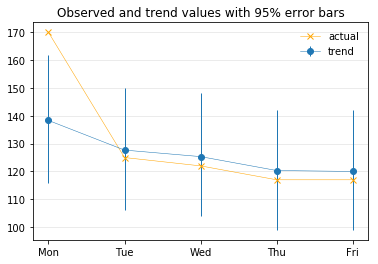

In [27]:
poisson_plot(ami_trend, ami_obs, kw2=dict(label='actual'),
             extra_code="plt.title('Observed and trend values with 95% error bars')");

In [28]:
H0 = NullHypothesis(ami_trend)
M0 = H0.marginal_likelihood(ami_obs)
print("Marginal likelihood of the null hypothesis (H0): {:.2e}".format(M0))

Marginal likelihood of the null hypothesis (H0): 1.56e-09


In [29]:
H1 = MondayHypothesis(ami_trend, 0.2)
M1 = H1.marginal_likelihood(ami_obs)
print("Marginal likelihood of the “following Monday” hypothesis (H1): {:.2e}".format(M1))

Marginal likelihood of the “following Monday” hypothesis (H1): 1.79e-08


In [30]:
B01 = M0 / M1

print(f"Bayes factor for H1:  M0:M1 = 1:{1/B01 :.1f} = {B01:.4f}")

Bayes factor for H1:  M0:M1 = 1:11.5 = 0.0873


In [31]:
H2 = WeekdaysHypothesis(ami_trend, 0.2)
M2 = H2.marginal_likelihood(ami_obs)
print("Marginal likelihood of the “following weekdays” hypothesis (H2): {:.2e}".format(M2))

Marginal likelihood of the “following weekdays” hypothesis (H2): 9.01e-11


In [32]:
B02 = M0 / M2

print(f"Bayes factor for H2:  M0:M2 = {B02:.1f} : 1")

Bayes factor for H2:  M0:M2 = 17.3 : 1


In [33]:
for hyp, ml in zip(['H0', 'H1', 'H2'], [M0, M1, M2]):
    marginal_likelihoods[hyp][PAPER_ID] = ml

## Sensitivity analysis

TODO: evaluate how sensitive are the marginal likelihoods to the choice of prior.

## Plot the prior/likelihood/posterior for Monday

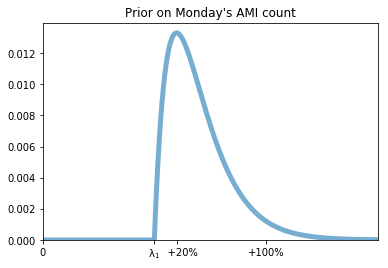

In [34]:
expected_increase = 0.2
p_min = ami_trend["Mon"]
p_spread = expected_increase * p_min
a = 2 # shape parameter
graph_max = p_min * 3
xs = np.linspace(0, graph_max, 1000)
plt.plot(xs, gamma.pdf(xs, a, loc=p_min, scale = p_spread),
         '-', lw=5, alpha=0.6)
plt.xticks([0, p_min, p_min + p_spread, 2 * p_min], ["0", "λ$_1$", "    +20%", "+100%"])
plt.xlim(0, graph_max)
plt.gca().set_ylim(bottom=0)
plt.title("Prior on Monday's AMI count")
plt.savefig("prior_monday.svg")
plt.show()

In [35]:
expected_monday_increase = 0.2

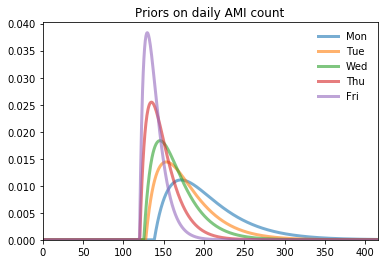

In [36]:
a = 2 # shape parameter
graph_max = ami_trend["Mon"] * 3


def f(dayname):
    expected_increase = expected_monday_increase * (6 - WEEKDAYS.index(dayname)) / 5
    p_min = ami_trend[dayname]
    p_spread = expected_increase * p_min
    xs = np.linspace(0, graph_max, 1000)
    plt.plot(xs, gamma.pdf(xs, a, loc=p_min, scale = p_spread),
             '-', lw=3, alpha=0.6, label=dayname)

for dayname in WEEKDAYS:
    f(dayname)
    
plt.xlim(0, graph_max)
plt.gca().set_ylim(bottom=0)
plt.gca().legend(loc='best', frameon=False)
plt.title("Priors on daily AMI count")
plt.savefig("prior_all.svg")
plt.show()

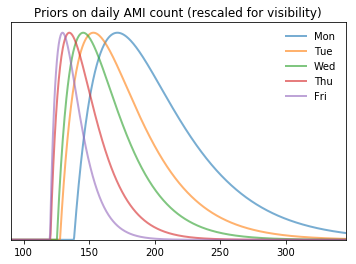

In [37]:
a = 2 # shape parameter
graph_min = 90
graph_max = ami_trend['Mon'] * 2.5
    
def f(dayname):
    expected_increase = expected_monday_increase * (6 - WEEKDAYS.index(dayname)) / 5
    p_min = ami_trend[dayname]
    p_spread = expected_increase * p_min
    xs = np.linspace(0, graph_max, 1000)
    plt.plot(xs, gamma.pdf(xs, a, loc=p_min, scale = p_spread) * p_spread,
             '-', lw=2, alpha=0.6, label=dayname)

for dayname in WEEKDAYS:
    f(dayname)
    
plt.xlim(graph_min, graph_max)
plt.yticks([])
plt.gca().set_ylim(bottom=0)
plt.gca().legend(loc='best', frameon=False)
plt.title("Priors on daily AMI count (rescaled for visibility)")
plt.savefig("prior_all_rescaled.svg")
plt.show()

In [38]:
total_count = 42060
total_days = 1354
total_mean = total_count / total_days

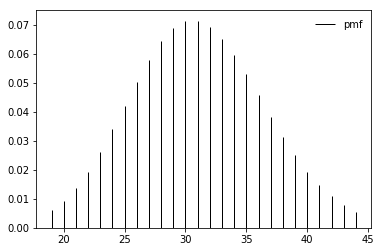

In [39]:
rv = poisson(total_mean)
x = np.arange(rv.ppf(0.01), rv.ppf(0.99))
fig, ax = plt.subplots(1, 1)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
          label='pmf')
ax.legend(loc='best', frameon=False)
ax.set_ylim(bottom=0.0)
plt.show()

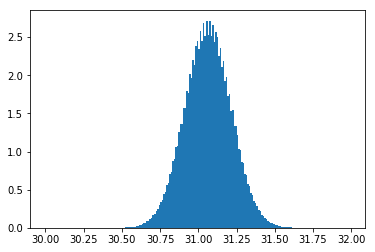

In [40]:
np.random.seed(0)

r = poisson(total_mean * total_days).rvs(10_000_000) / total_days
plt.hist(r, bins=np.arange(30, 32, 0.01), density=True)
plt.show()